<a href="https://colab.research.google.com/github/Nzaya/Titanic-Prediction-and-Spam-Prediction/blob/master/Moringa_Data_Science_Core_W9_Independent_Project_2019_06_Sharon_Nzaya_Python_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TITANIC** **PREDICTION**

In [0]:
#Loading the necessary libraries
#Data Analysis
import pandas as pd
import numpy as np
import random as rnd

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [169]:
#Loading the train data

train=pd.read_csv('/content/train.csv', header = 0, dtype={'Age': np.float64})
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [170]:
#Loading the test data

test=pd.read_csv('/content/test.csv', header = 0, dtype={'Age': np.float64})
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [171]:
#Printing the train column

print(train.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [172]:
#Combining the train and test so as to do EDA once

full_data= [train, test]
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


## **Feature** **Engineering**

Pclass

In [173]:
print (train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


Sex

In [174]:
print (train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean())

      Sex  Survived
0  female  0.742038
1    male  0.188908


**SibSp**

In [175]:
train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


**Parch**

In [176]:
train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


**SibSp and Parch**

With the number of siblings/spouse and the number of children/parents we can create a new feature called **Family Size**

In [177]:
for dataset in full_data:
  dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
print (train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean())

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


Let us check if people were Alone or Not

In [178]:
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
print (train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean())

   IsAlone  Survived
0        0  0.505650
1        1  0.303538


**Embarked**

This has some missing values.It has three possible values. S port used by most passengers. We fill the missing values with 'S





In [179]:
for dataset in full_data:
  dataset['Embarked'] = dataset['Embarked'].fillna('S')
print (train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean())

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


**Fare**

In [180]:
for dataset in full_data:
  dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
print (train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean())

   CategoricalFare  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081


**Age**

We have plenty of missing values here , so we will generate random numbers between(mean-std)and (mean+std), then we categorize age into 5 range

In [0]:
#Finding the mean and std.
#Finding the number of missing values in the Age column

for dataset in full_data:
  age_avg= train['Age'].mean()
  age_std= train['Age'].std()
  age_null_count= train['Age'].isnull().sum()

In [182]:

age_null_random_list= np.random.randint(age_avg-age_std ,age_avg+age_std, size= age_null_count)
train['Age'][np.isnan(train['Age'])]= age_null_random_list
train['Age']= train['Age'].astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [183]:
train['CategoricalAge']= pd.cut(train['Age'],5)
print(train[['CategoricalAge','Survived']].groupby(['CategoricalAge'], as_index=False).mean())

  CategoricalAge  Survived
0  (-0.08, 16.0]  0.541284
1   (16.0, 32.0]  0.351474
2   (32.0, 48.0]  0.371648
3   (48.0, 64.0]  0.434783
4   (64.0, 80.0]  0.090909


**Name**

We can find the title of people


The RegEx pattern (\w+\.) matches the first word which ends with a dot character within Name feature.

 The expand=False flag returns a DataFrame.

In [0]:
def get_title(name):
  title_search= re.search('([A-Za-z]+\.',name)
  #If title exist, extract and return it
  if title_search:
    return title_search.group(1)
  return ""

In [185]:
for dataset in full_data:
  dataset['Title']= dataset.Name.str.extract('([A-Za-z]+)\.',expand= False)
pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


We have Titles now let's categorize it and check the title impact on Survival Rates

In [186]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


# VISUALIZING DATA

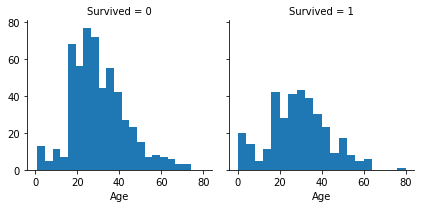

In [187]:
g = sns.FacetGrid(train, col='Survived')
g.map(plt.hist, 'Age', bins=20)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


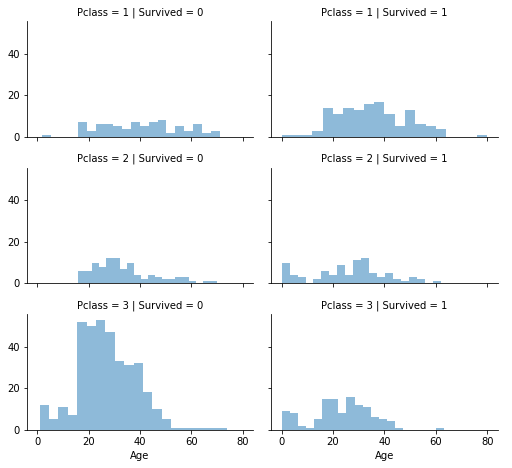

In [188]:
# grid = sns.FacetGrid(train, col='Pclass', hue='Survived')

grid = sns.FacetGrid(train, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:720: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


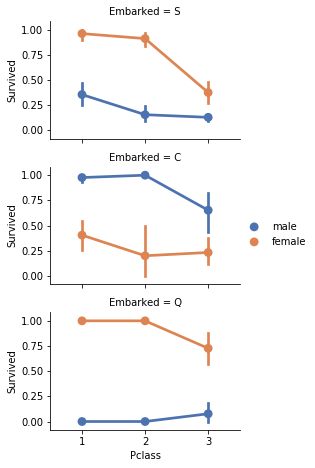

In [189]:
# grid = sns.FacetGrid(train, col='Embarked')

grid = sns.FacetGrid(train, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


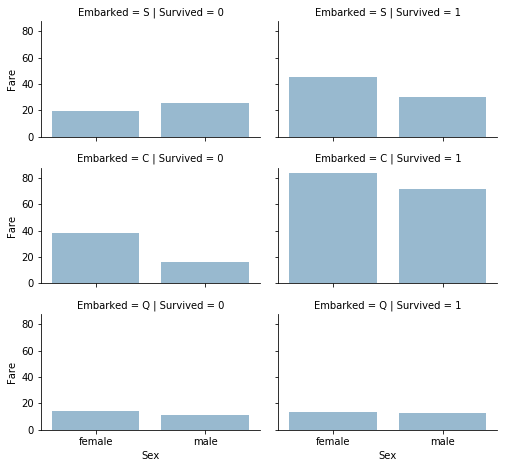

In [190]:
# grid = sns.FacetGrid(train, col='Embarked', hue='Survived', palette={0: 'k', 1: 'w'})

grid = sns.FacetGrid(train, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

# DATA CLEANING

In [0]:
#Mapping Sex so that Female will be 0 and male will be 1

dataset['Sex']= dataset['Sex'].map({'female': 0, 'male':1}).astype(int)

In [0]:
#Mapping Titles

title_mapping= {'Mr':1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Rare': 5}
dataset['Title']= dataset['Title'].map(title_mapping)
dataset['Title']= dataset['Title'].fillna(0)

In [0]:
#Mapping Embarked

dataset['Embarked']=dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}). astype(int)


Fare

We can now complete the Fare feature for single missing value in test dataset using mode to get the value that occurs most frequently for this feature. We do this in a single line of code.

Note that we are not creating an intermediate new feature or doing any further analysis for correlation to guess missing feature as we are replacing only a single value. The completion goal achieves desired requirement for model algorithm to operate on non-null values.

We may also want round off the fare to two decimals as it represents currency.


In [0]:
dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
dataset['Fare'] = dataset['Fare'].astype(int)
    

In [0]:
#Map Age

dataset.loc[ dataset['Age'] <= 16, 'Age']= 0
dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [196]:
# Feature Selection
#drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp',\
                 #'Parch', 'FamilySize']
#train = train.drop([drop_elements], axis = 1)
#train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)

#test  = test.drop(drop_elements, axis = 1)

print (train.head(10))

train = train.values
test  = test.values
  

   PassengerId  Survived  Pclass  ...  CategoricalFare CategoricalAge   Title
0            1         0       3  ...   (-0.001, 7.91]   (16.0, 32.0]      Mr
1            2         1       1  ...  (31.0, 512.329]   (32.0, 48.0]     Mrs
2            3         1       3  ...   (7.91, 14.454]   (16.0, 32.0]    Miss
3            4         1       1  ...  (31.0, 512.329]   (32.0, 48.0]     Mrs
4            5         0       3  ...   (7.91, 14.454]   (32.0, 48.0]      Mr
5            6         0       3  ...   (7.91, 14.454]   (32.0, 48.0]      Mr
6            7         0       1  ...  (31.0, 512.329]   (48.0, 64.0]      Mr
7            8         0       3  ...   (14.454, 31.0]  (-0.08, 16.0]  Master
8            9         1       3  ...   (7.91, 14.454]   (16.0, 32.0]     Mrs
9           10         1       2  ...   (14.454, 31.0]  (-0.08, 16.0]     Mrs

[10 rows x 17 columns]


#Classifier Comparison

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

In [0]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
	AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

In [0]:
log_cols = ["Classifier", "Accuracy"]
log 	 = pd.DataFrame(columns=log_cols)

In [0]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = train[0::, 1::]
y = train[0::, 0]

acc_dict = {}

In [201]:
for train_index, test_index in sss.split(X, y):
	X_train, X_test = X[train_index], X[test_index]
	y_train, y_test = y[train_index], y[test_index]

ValueError: ignored

In [0]:
for clf in classifiers:
		name = clf.__class__.__name__
		clf.fit(X_train, y_train)
		train_predictions = clf.predict(X_test)
		acc = accuracy_score(y_test, train_predictions)
		if name in acc_dict:
			acc_dict[name] += acc
		else:
			acc_dict[name] = acc

In [0]:
for clf in acc_dict:
	acc_dict[clf] = acc_dict[clf] / 10.0
	log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
	log = log.append(log_entry)

In [0]:
plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

In [0]:
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

# Prediction

Now we can use SVC classifier to predict our data.

In [0]:
candidate_classifier = SVC()
candidate_classifier.fit(train[0::, 1::], train[0::, 0])
result = candidate_classifier.predict(test)